In [1]:
import pandas as pd
from paper import ANOMALY_CATEGORIES, Signals, load_pandas_dataframes, load_numpy_arrays
from configuration import Configuration

/Users/mattia/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import dataset

In [7]:
ds = dataset.VorAusDataset('dataset.parquet')

In [8]:
X_train, y_train, X_test, y_test = ds.get_prepared_dataset_tts(test_size=.15,random_state=42)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from sklearn.metrics import roc_auc_score

In [13]:
clf = KNN()
clf.fit(X_train)
test_scores = clf.decision_function(X_test)
roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
print(roc)

In [16]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)

DecisionTreeClassifier()

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve,auc, RocCurveDisplay

In [17]:
y_pred = dtc.predict(X_test)

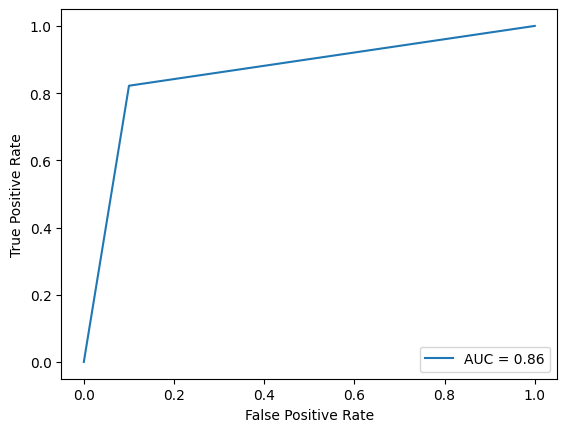

In [26]:
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

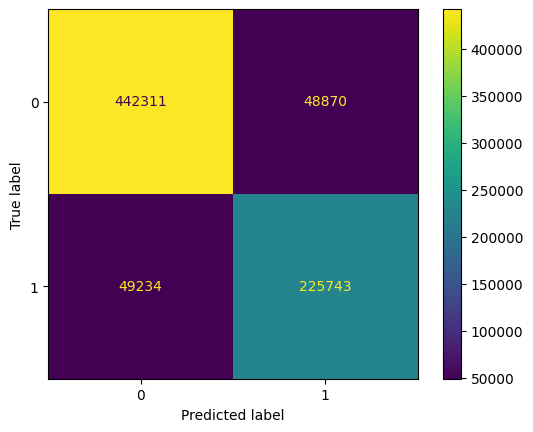

In [18]:
cm = confusion_matrix(y_pred, y_test)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [17]:
from sklearn.svm import OneClassSVM

In [ ]:
clf = OneClassSVM(gamma='auto').fit(X)